<a href="https://colab.research.google.com/github/YoonSungLee/AI-Innovation-Square_Vision/blob/master/Day%204_CNN%20%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0/VGG4smalldataset_with_prediction(API_%EC%A0%9C%EA%B1%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()


# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 1. 홈 디렉토리에 datasets 폴더 생성 후, 그 안에 cats_and_dogs_small 폴더를 생성 합니다.
# 2. cats_and_dogs_small 안에 train, test, validation 폴더가 위치 하도록 압축을 풉니다.
cd gdrive/My Drive/datasets/cats_and_dogs_small

/content/gdrive/My Drive/datasets/cats_and_dogs_small


In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 안정적으로 이미지의 갯수를 늘리는 방법
# 개인 하드웨어에 저장해서 반복적으로 opencv 이용


# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)



base_dir = '/content/gdrive/My Drive/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')


train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 224 × 224 크기로 바꿉니다
        target_size=(224, 224),
        batch_size=2,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='categorical')

# validation_generator = test_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(224, 224),
#         batch_size=20,
#         class_mode='binary')

Found 197 images belonging to 2 classes.


In [0]:
for data_batch, labels_batch in train_generator:
    print 'Batch size:', data_batch.shape
    print 'Label size:', labels_batch.shape
    break

Batch size: (2, 224, 224, 3)
Label size: (2, 2)


In [0]:
labels_batch

array([[1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
#  This code cell shows how to utilize VGG16 model by combining Dense layer at the end of the network 
# GlobalAveragePooling2D : flatten을 하지 않고 각 feature map의 평균값을 펼쳐서 이용하는 방법
# GlobalAveragePooling2D : image classification에 뛰어난 성능 발휘
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras import layers
from keras import models

VGGNet = VGG16()
VGGNet.summary()


  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# We will not update VGG pre-trained model, only added Dense layers will be trained from the scratch
# frozen : layer의 update(backpropagation)을 중지, input data가 적을 경우 사용
# fine tuning : 모든 layer를 layer.trainable = True로 설정(학습된 모델에 추가적인 학습 진행)

for layer in VGGNet.layers:
  layer.trainable = False
  
vgg_maxpool5 = VGGNet.get_layer('block5_pool').output

Feature_Flatten = Flatten()(vgg_maxpool5) # keras를 model 형식으로 사용하지 않을 경우
dense = Dense(1024, name='dense', activation='relu')(Feature_Flatten)
predictions = Dense(2, activation='softmax')(dense)

New_VGGmodel = Model(inputs=VGGNet.input, outputs=predictions) # 연결되어있는 모델을 스스로 가져와서 모델링
New_VGGmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

New_VGGmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# fit_generator : batch_size를 입력했기 때문에 steps_per_epoch를 직접 설정
# 사용하고 있는 메모리에 따라서 batch_size를 결정
정
history = New_VGGmodel.fit_generator(
    train_generator,
#     validation_data=validation_generator, 
#     validation_steps=10,
    steps_per_epoch=30,
    epochs=5
)

W0206 13:02:25.443886 140283883456384 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0206 13:02:25.493210 140283883456384 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0206 13:02:25.498635 140283883456384 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5
30/30 [==============================] - 36s 1s/step - loss: 8.3488 - acc: 0.4667
Epoch 2/5
30/30 [==============================] - 35s 1s/step - loss: 7.2531 - acc: 0.5500
Epoch 3/5
30/30 [==============================] - 37s 1s/step - loss: 7.7904 - acc: 0.5167
Epoch 4/5
30/30 [==============================] - 10s 335ms/step - loss: 9.1298 - acc: 0.4336
Epoch 5/5
30/30 [==============================] - 1s 30ms/step - loss: 8.8650 - acc: 0.4500


In [0]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [0]:
pip install flickrapi

     |████████████████████████████████| 61kB 8.8MB/s 


In [0]:
# 웹에서 image를 가져와 모델을 평가하는 부분

from flickrapi import FlickrAPI

FLICKER_KEY = '*****'
FLICKER_SECRET = '*****'

flickr = FlickrAPI(FLICKER_KEY, FLICKER_SECRET, format='parsed-json')
extras='url_s'
cats = flickr.photos.search(text='kitten', per_page=5, extras=extras)
photos = cats['photos']

In [0]:
# import the necessary packages
import numpy as np
import urllib
import cv2

def url_to_image(url):
  resp = urllib.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

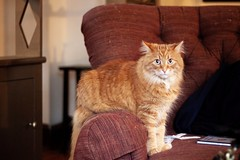

In [0]:
from google.colab.patches import cv2_imshow

image_original_url = photos['photo'][0]['url_s']

image_temp = url_to_image(image_original_url)
cv2_imshow(image_temp)

In [0]:
# 이미지 크기 설정

resized_image = cv2.resize(image_temp, (224, 224))
print resized_image.shape

(224, 224, 3)


In [0]:
# dimension 설정

resized_image = np.expand_dims(resized_image, axis=0)
print resized_image.shape

(1, 224, 224, 3)


In [0]:
result = New_VGGmodel.predict(resized_image)

In [0]:
result

array([[1., 0.]], dtype=float32)

In [0]:
New_VGGmodel.save('MyVGGNet.h5') # model, weight 저장

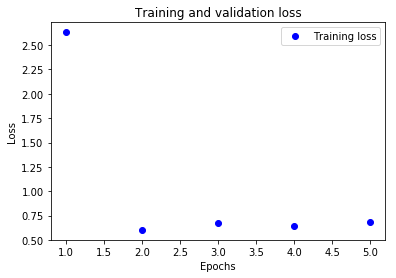

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()